# Загрузка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_files
import srt
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from datasets import Dataset,DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
#from transformers import TFAutoModelForSequenceClassification,AutoTokenizer, TFTrainingArguments, TFTrainer
#import tensorflow as tf
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [184]:
movie_labels = pd.read_excel('movies_labels.xlsx', names=['id', 'movie', 'level']).drop('id', axis=1)
subtitles_files = load_files('Subtitles/', shuffle=False)

In [185]:
print(movie_labels.info())
movie_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   241 non-null    object
 1   level   241 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB
None


,movie,level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


In [186]:
subtitles = pd.DataFrame(data={'data': subtitles_files.data, 
                          'filenames': subtitles_files.filenames})
subtitles.head()

,data,filenames
0,"b'1\n00:00:03,169 --> 00:00:05,171\n( bugs chi...",Subtitles/A2\The Walking Dead-S01E01-Days Gone...
1,"b'1\n00:00:03,045 --> 00:00:05,047\n- ( birds ...",Subtitles/A2\The Walking Dead-S01E02-Guts.Engl...
2,"b'1\n00:00:03,003 --> 00:00:04,671\n( thunder ...",Subtitles/A2\The Walking Dead-S01E03-Tell It T...
3,"b'1\n00:00:03,045 --> 00:00:05,422\n( birds ch...",Subtitles/A2\The Walking Dead-S01E04-Vatos.Eng...
4,"b""1\n00:00:03,420 --> 00:00:04,922\n- ( walkie...",Subtitles/A2\The Walking Dead-S01E05-Wildfire....


# Предобработка данных

## subtitles

deleted :
* Crown, The S01E03 - Windsor.en.FORCED.srt
* Crown, The S01E05 - Smoke and Mirrors.en.FORCED.srt
* Crown, The S01E07 - Scientia Potentia Est.en.FORCED.srt
* Crown, The S01E10 - Gloriana.en.FORCED.srt

reformatted:
* Suits season 4

In [187]:
subtitles.head()

,data,filenames
0,"b'1\n00:00:03,169 --> 00:00:05,171\n( bugs chi...",Subtitles/A2\The Walking Dead-S01E01-Days Gone...
1,"b'1\n00:00:03,045 --> 00:00:05,047\n- ( birds ...",Subtitles/A2\The Walking Dead-S01E02-Guts.Engl...
2,"b'1\n00:00:03,003 --> 00:00:04,671\n( thunder ...",Subtitles/A2\The Walking Dead-S01E03-Tell It T...
3,"b'1\n00:00:03,045 --> 00:00:05,422\n( birds ch...",Subtitles/A2\The Walking Dead-S01E04-Vatos.Eng...
4,"b""1\n00:00:03,420 --> 00:00:04,922\n- ( walkie...",Subtitles/A2\The Walking Dead-S01E05-Wildfire....


In [188]:
subtitles['data'] = subtitles['data'].str.decode('ISO-8859-1')

In [189]:
def get_name_and_level(row):
    level = row.split('\\')[0][10:]
    name = row.split('\\')[1][:-4]
    return pd.Series([name, level])

In [190]:
subtitles[['movie', 'level']] = subtitles['filenames'].apply(get_name_and_level)
subtitles = subtitles.drop('filenames', axis=1)

In [191]:
subtitles['movie'] = subtitles['movie'].str.lower()

In [192]:
subtitles.head()

,data,movie,level
0,"1\n00:00:03,169 --> 00:00:05,171\n( bugs chitt...",the walking dead-s01e01-days gone bye.english,A2
1,"1\n00:00:03,045 --> 00:00:05,047\n- ( birds ch...",the walking dead-s01e02-guts.english,A2
2,"1\n00:00:03,003 --> 00:00:04,671\n( thunder ru...",the walking dead-s01e03-tell it to the frogs.e...,A2
3,"1\n00:00:03,045 --> 00:00:05,422\n( birds chir...",the walking dead-s01e04-vatos.english,A2
4,"1\n00:00:03,420 --> 00:00:04,922\n- ( walkie-t...",the walking dead-s01e05-wildfire.english,A2


In [193]:
subtitles.describe()

,data,movie,level
count,275,275,275
unique,274,275,5
top,"1\n00:01:25,210 --> 00:01:28,004\nI owe everyt...",the walking dead-s01e01-days gone bye.english,Unlabeled
freq,2,1,116


In [194]:
subtitles[subtitles['data'].duplicated(keep=False)]

,data,movie,level
207,"1\n00:01:25,210 --> 00:01:28,004\nI owe everyt...",it_s_a_wonderful_life(1946),Unlabeled
208,"1\n00:01:25,210 --> 00:01:28,004\nI owe everyt...",its_a_wonderful_life(1946),Unlabeled


In [195]:
subtitles = subtitles.drop(subtitles[subtitles['data'].duplicated()].index, axis=0)

## movie_labels

In [196]:
movie_labels.isna().sum()

movie    0
level    0
dtype: int64

In [197]:
movie_labels.describe()

,movie,level
count,241,241
unique,237,7
top,Powder(1995),B2
freq,2,101


### movie

In [198]:
movie_labels['movie'] = movie_labels['movie'].str.lower()

In [199]:
movie_labels.duplicated().sum()

2

In [200]:
movie_labels = movie_labels.drop_duplicates()

In [201]:
print(movie_labels[movie_labels['movie'].duplicated(keep=False)].index)
movie_labels[movie_labels['movie'].duplicated(keep=False)]

Int64Index([75, 83, 84, 99], dtype='int64')


,movie,level
75,the_blind_side(2009),B2
83,the_terminal(2004),B1
84,the_blind_side(2009),B1
99,the_terminal(2004),"A2/A2+, B1"


https://moviesbylevels.wordpress.com/

In [202]:
movie_labels = movie_labels.drop([84, 99], axis=0)

### level

In [203]:
movie_labels = movie_labels.reset_index(drop=True)

In [204]:
movie_labels['level'].value_counts()

B2            101
B1             52
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      4
Name: level, dtype: int64

In [205]:
indexes = movie_labels[movie_labels['level'] == 'A2/A2+, B1'].index
movie_labels[movie_labels['level'] == 'A2/A2+, B1']

,movie,level
35,forrest_gump(1994),"A2/A2+, B1"
39,her(2013),"A2/A2+, B1"
59,moulin_rouge(2001),"A2/A2+, B1"
84,the_fault_in_our_stars(2014),"A2/A2+, B1"


In [206]:
movie_labels['level'].iloc[indexes[0]] = 'A2'
movie_labels['level'].iloc[indexes[1]] = 'B1'
movie_labels['level'].iloc[indexes[2]] = 'B1'
movie_labels['level'].iloc[indexes[3]] = 'A2'

In [207]:
indexes = movie_labels[movie_labels['level'] == 'B1, B2'].index
movie_labels[movie_labels['level'] == 'B1, B2']

,movie,level
13,before_sunrise(1995),"B1, B2"
14,before_sunset(2004),"B1, B2"
16,bridget_jones_diary(2001),"B1, B2"
20,catch_me_if_you_can(2002),"B1, B2"
49,lion(2016),"B1, B2"
80,the_shawshank_redemption(1994),"B1, B2"
85,the_graduate(1967),"B1, B2"
92,the_lord_of_the_rings(2001),"B1, B2"


In [208]:
movie_labels['level'].iloc[indexes[0]] = 'B1'
movie_labels['level'].iloc[indexes[1]] = 'B1'
movie_labels['level'].iloc[indexes[2]] = 'B1'
movie_labels['level'].iloc[indexes[3]] = 'B2'
movie_labels['level'].iloc[indexes[4]] = 'B2'
movie_labels['level'].iloc[indexes[5]] = 'B2'
movie_labels['level'].iloc[indexes[6]] = 'B2'
movie_labels['level'].iloc[indexes[7]] = 'B1'

In [209]:
movie_labels['level'] = movie_labels['level'].str.replace('A2/A2+', 'A2', regex=False)

In [210]:
movie_labels['level'].value_counts()

B2    105
B1     58
C1     40
A2     34
Name: level, dtype: int64

## merge

In [211]:
df = pd.merge(subtitles, movie_labels, how='outer', on=['movie'])

In [212]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 282
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   data     274 non-null    object
 1   movie    283 non-null    object
 2   level_x  274 non-null    object
 3   level_y  237 non-null    object
dtypes: object(4)
memory usage: 11.1+ KB


None

,data,movie,level_x,level_y
0,"1\n00:00:03,169 --> 00:00:05,171\n( bugs chitt...",the walking dead-s01e01-days gone bye.english,A2,A2
1,"1\n00:00:03,045 --> 00:00:05,047\n- ( birds ch...",the walking dead-s01e02-guts.english,A2,A2
2,"1\n00:00:03,003 --> 00:00:04,671\n( thunder ru...",the walking dead-s01e03-tell it to the frogs.e...,A2,A2
3,"1\n00:00:03,045 --> 00:00:05,422\n( birds chir...",the walking dead-s01e04-vatos.english,A2,A2
4,"1\n00:00:03,420 --> 00:00:04,922\n- ( walkie-t...",the walking dead-s01e05-wildfire.english,A2,A2


In [213]:
display(df.describe())
df.isna().sum()

,data,movie,level_x,level_y
count,274,283,274,237
unique,274,283,5,4
top,"1\n00:00:03,169 --> 00:00:05,171\n( bugs chitt...",the walking dead-s01e01-days gone bye.english,Unlabeled,B2
freq,1,1,115,105


data        9
movie       0
level_x     9
level_y    46
dtype: int64

### data

In [214]:
df[df['data'].isna()]

,data,movie,level_x,level_y
274,NaN,its_a_wonderful_life(1946),NaN,A2
275,NaN,the secret life of pets.en,NaN,B2
276,NaN,up (2009),NaN,A2
277,NaN,glass onion,NaN,B2
278,NaN,matilda(2022),NaN,C1
279,NaN,bullet train,NaN,B1
280,NaN,thor: love and thunder,NaN,B2
281,NaN,lightyear,NaN,B2
282,NaN,the grinch,NaN,B1


#### its_a_wonderful_life(1946)

In [215]:
df[df['movie'].str.contains('wonderful')]

,data,movie,level_x,level_y
207,"1\n00:01:25,210 --> 00:01:28,004\nI owe everyt...",it_s_a_wonderful_life(1946),Unlabeled,NaN
274,NaN,its_a_wonderful_life(1946),NaN,A2


In [216]:
df['level_x'].iloc[207] = df['level_y'].iloc[276]
df = df.drop(276, axis=0)
df = df.reset_index(drop=True)

#### he secret life of pets.en

In [217]:
df[df['movie'].str.contains('pet')]

,data,movie,level_x,level_y
275,NaN,the secret life of pets.en,NaN,B2


https://subscene.com/subtitles/the-secret-life-of-pets/english/1440256

In [218]:
subs = open('Missing_subtitles/The.Secret.Life.of.Pets.2016.720p.BRRip.x264.AAC-ETRG.srt', 'r', encoding='ISO-8859-1')
df['data'].iloc[274] = subs.read()
subs.close()

#### up (2009)

In [219]:
df[df['movie'].str.contains('up')]

,data,movie,level_x,level_y
245,"1\n00:00:29,500 --> 00:00:31,200\n(CROWD CHEER...",the_break-up(2006),Unlabeled,A2
267,"1\n00:00:46,040 --> 00:00:50,960\n{\i1}Movieto...",up(2009),Unlabeled,NaN


In [220]:
df['level_x'].iloc[267] = df['level_y'].iloc[275]
df = df.drop(275, axis=0)
df = df.reset_index(drop=True)

#### glass onion

In [221]:
df[df['movie'].str.contains('onion')]

,data,movie,level_x,level_y
275,NaN,glass onion,NaN,B2


https://subscene.com/subtitles/glass-onion-a-knives-out-mystery/english/2960299

In [222]:
subs = open('Missing_subtitles/Glass.Onion.A Knives.Out.Mystery.2022.1080p.NF.WEB-DL.DDP5.1.Atmos.x264.srt', 'r',  encoding='ISO-8859-1')
df['data'].iloc[275] = subs.read()
subs.close()

#### matilda(2022)

In [223]:
df[df['movie'].str.contains('matilda')]

,data,movie,level_x,level_y
218,"1\n00:00:21,688 --> 00:00:24,692\n<i><font col...",matilda(1996),Unlabeled,B1
276,NaN,matilda(2022),NaN,C1


https://subscene.com/subtitles/roald-dahls-matilda-the-musical/english/2968073

In [224]:
subs = open("Missing_subtitles/Roald Dahl's Matilda the Musical (2022).srt", 'r',  encoding='ISO-8859-1')
df['data'].iloc[276] = subs.read()
subs.close()

#### bullet train

In [225]:
df[df['movie'].str.contains('train')]

,data,movie,level_x,level_y
277,NaN,bullet train,NaN,B1


https://subscene.com/subtitles/bullet-train/english/3035799

In [226]:
subs = open('Missing_subtitles/Bullet.Train.Eng.2022.NoHI.srt', 'r',  encoding='ISO-8859-1')
df['data'].iloc[277] = subs.read()
subs.close()

#### thor: love and thunder

In [227]:
df[df['movie'].str.contains('thor')]

,data,movie,level_x,level_y
278,NaN,thor: love and thunder,NaN,B2


https://subscene.com/subtitles/thor-love-and-thunder/english/2878411

In [228]:
subs = open('Missing_subtitles/Thor.Love.and.Thunder.2022.1080p.WEBRip.X264.DD5.1.srt', 'r',  encoding='ISO-8859-1')
df['data'].iloc[278] = subs.read()
subs.close()

#### lightyear

In [229]:
df[df['movie'].str.contains('lightyear')]

,data,movie,level_x,level_y
279,NaN,lightyear,NaN,B2


https://subscene.com/subtitles/lightyear/english/2857387

In [230]:
subs = open('Missing_subtitles/Lightyear.2022.WEBRip.x264-PS.srt', 'r',  encoding='ISO-8859-1')
df['data'].iloc[279] = subs.read()
subs.close()

#### the grinch

In [231]:
df[df['movie'].str.contains('grinch')]

,data,movie,level_x,level_y
110,"ï»¿1\r\n00:00:25,735 --> 00:00:26,736\r\nIllum...",the.grinch.2018.remux.1080p.blu-ray.avc.truehd...,B2,NaN
280,NaN,the grinch,NaN,B1


In [232]:
df = df.drop(280, axis=0)
df = df.reset_index(drop=True)

#### Дубликаты

In [233]:
df['data'].duplicated().sum()

0

### moive

In [234]:
df['movie'].duplicated().sum()

0

### level

In [235]:
df[df['level_x'].isna()]

,data,movie,level_x,level_y
274,"ï»¿1\n00:00:25,440 --> 00:00:27,908\n<b>(HUMMI...",its_a_wonderful_life(1946),NaN,A2
275,"ï»¿1\n00:00:26,458 --> 00:00:29,625\nNo, subje...",glass onion,NaN,B2
276,"ï»¿1\n00:01:16,833 --> 00:01:20,333\n<i>My mum...",matilda(2022),NaN,C1
277,"ï»¿1\n00:01:40,892 --> 00:01:43,634\nThe booms...",bullet train,NaN,B1
278,"ï»¿1\n00:00:41,834 --> 00:00:43,877\nOh, great...",thor: love and thunder,NaN,B2
279,"1\n00:01:42,895 --> 00:01:45,939\nBuzz Lightye...",lightyear,NaN,B2


In [236]:
df['level_x'] = df['level_x'].fillna(df['level_y'])

In [237]:
display(df['level_y'].unique())
df['level_x'].value_counts()

array(['A2', 'B1', nan, 'B2', 'C1'], dtype=object)

Unlabeled    113
B2           107
C1            34
B1            18
A2             8
Name: level_x, dtype: int64

In [238]:
indexes = df[(df['level_x'] == 'Unlabeled') & (df['level_y'].isna())].index
df[(df['level_x'] == 'Unlabeled') & (df['level_y'].isna())]

,data,movie,level_x,level_y
175,"1\n00:00:05,299 --> 00:00:08,220\nwhat hi good...",breaking_bad_the_movie(2017),Unlabeled,NaN
176,"ï»¿1\r\n00:00:07,216 --> 00:00:09,676\r\n[pres...",brenв.brown.the.call.to.courage.2019.720.nf.72...,Unlabeled,NaN
180,"1\n00:00:18,040 --> 00:00:21,870\n[Music]\n\n2...",casper,Unlabeled,NaN
198,"1\n00:00:01,130 --> 00:00:18,359\n[Music]\n\n2...",gogo_loves_english,Unlabeled,NaN
201,"1\n00:01:22,065 --> 00:01:27,070\nI should've ...",harry_potter_and_the_philosophers_stone(2001),Unlabeled,NaN
231,"1\n00:00:20,020 --> 00:00:42,009\n[Music]\n\n2...",pride_and_prejudice,Unlabeled,NaN
240,"1\n00:00:04,670 --> 00:00:18,579\n[Music]\n\n2...",the_ghost_writer,Unlabeled,NaN
271,"1\n00:00:00,000 --> 00:00:21,179\n[Music]\n\n2...",westworld_scenes_of_dr_robert_ford,Unlabeled,NaN


In [239]:
df['level_x'].iloc[indexes[0]] = 'B2'
df['level_x'].iloc[indexes[1]] = 'B2'
df['level_x'].iloc[indexes[2]] = 'A2'
df['level_x'].iloc[indexes[3]] = 'A2' #A1 not present in dataset
df['level_x'].iloc[indexes[4]] = 'A2'
df['level_x'].iloc[indexes[5]] = 'B2'
df['level_x'].iloc[indexes[6]] = 'B2'
df['level_x'].iloc[indexes[7]] = 'B2'

In [240]:
df.iloc[23][2]

'B2'

In [241]:
df['level_x'] = df[['level_x', 'level_y']].apply(lambda x: x['level_x'] if x['level_x'] != 'Unlabeled' else x['level_y'], axis=1)

In [242]:
df['level_x'].unique()

array(['A2', 'B1', 'B2', 'C1'], dtype=object)

In [243]:
df = df.drop(['level_y', 'movie'], axis=1)

In [244]:
df = df.rename(columns={'level_x': 'level'})

In [245]:
df.head()

,data,level
0,"1\n00:00:03,169 --> 00:00:05,171\n( bugs chitt...",A2
1,"1\n00:00:03,045 --> 00:00:05,047\n- ( birds ch...",A2
2,"1\n00:00:03,003 --> 00:00:04,671\n( thunder ru...",A2
3,"1\n00:00:03,045 --> 00:00:05,422\n( birds chir...",A2
4,"1\n00:00:03,420 --> 00:00:04,922\n- ( walkie-t...",A2


## subtitle processing

In [246]:
def parse_subtitles(data):
    subtitle_generator = srt.parse(data, ignore_errors=True);
    subs = list(subtitle_generator)
    subs_text = []
    for i in range(len(subs)):
        subs_text.append(subs[i].content)
    
    return(' '.join(subs_text))

In [247]:
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [248]:
def tokenize_and_clean(data):
    data_tokenized = nltk.word_tokenize(data)
    stopwords = nltk.corpus.stopwords.words('english')
    data_cleaned = [word for word in data_tokenized if word.lower() not in stopwords]
    data_cleaned = [word.lower() for word in data_cleaned if word.isalpha()]
    lemm = WordNetLemmatizer()
    data_lemmatized = [lemm.lemmatize(w) for w in data_cleaned]
    return data_lemmatized

In [249]:
df['data'] = df['data'].apply(parse_subtitles)
df['data'] = df['data'].apply(remove_html_tags)

In [250]:
df['data'] = df['data'].apply(tokenize_and_clean)

In [251]:
level_a2 = df[df['level'] == 'A2']['data'].values
level_a2 = np.concatenate(level_a2, axis=0)
level_b1 = df[df['level'] == 'B1']['data'].values
level_b1 = np.concatenate(level_b1, axis=0)
level_b2 = df[df['level'] == 'B2']['data'].values
level_b2 = np.concatenate(level_b2, axis=0)
level_c1 = df[df['level'] == 'C1']['data'].values
level_c1 = np.concatenate(level_c1, axis=0)

# Исследовательский анализ данных

## level

<Axes: ylabel='level'>

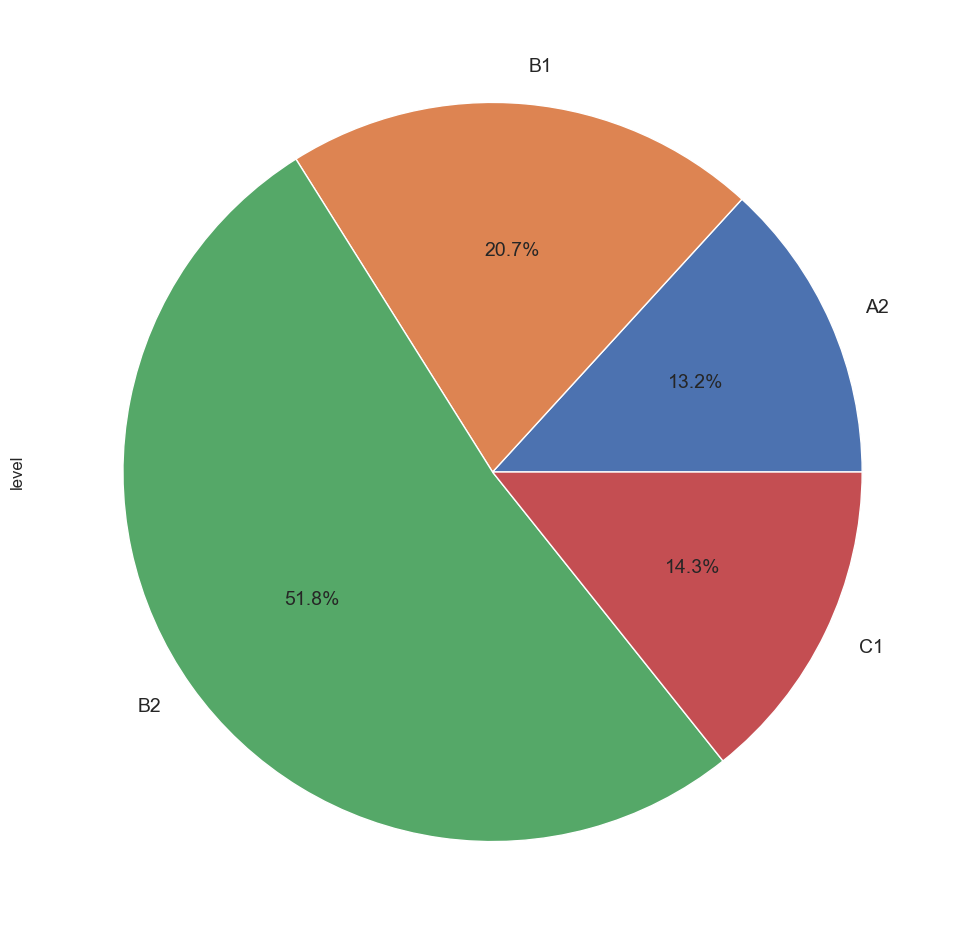

In [252]:
level_counts = df.groupby('level')['level'].count()
fig, ax = plt.subplots(figsize = (12,12))
ax.grid(False)
fig.patch.set_facecolor('w')
level_counts.plot(kind='pie', autopct='%1.1f%%',  textprops={'fontsize': 14})

## data

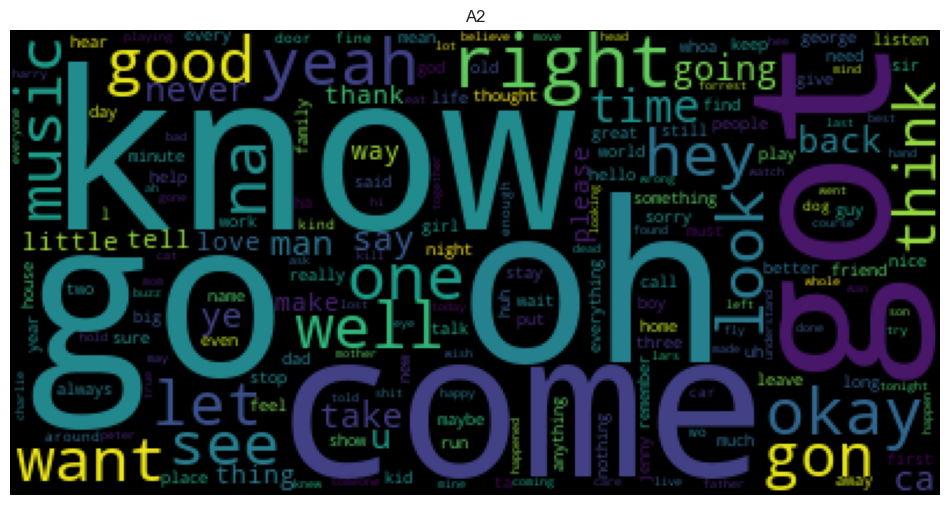

In [253]:
plt.figure(figsize=(12, 20))
wordcloud = WordCloud(collocations=False, stopwords=STOPWORDS, background_color='black').generate(' '.join(level_a2))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('A2')
plt.show()

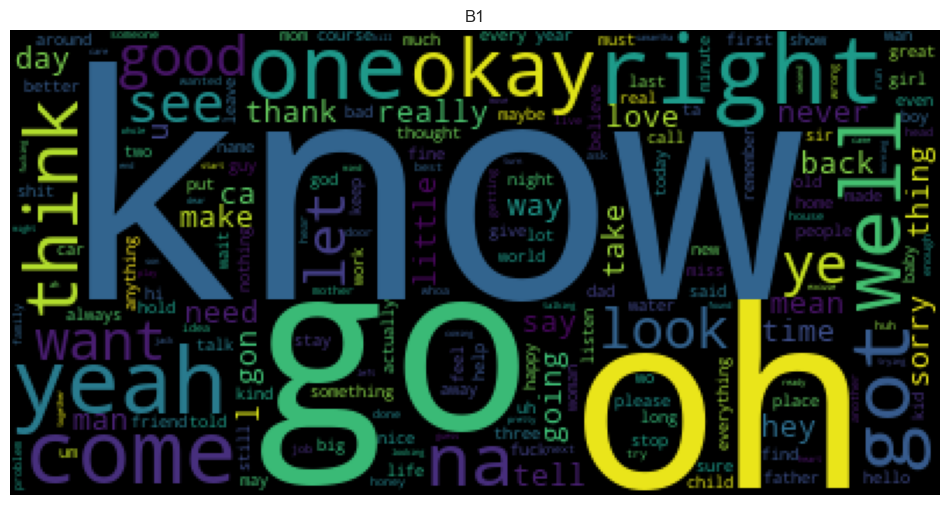

In [254]:
plt.figure(figsize=(12, 20))
wordcloud = WordCloud(collocations=False, stopwords=STOPWORDS, background_color='black').generate(' '.join(level_b1))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('B1')
plt.show()

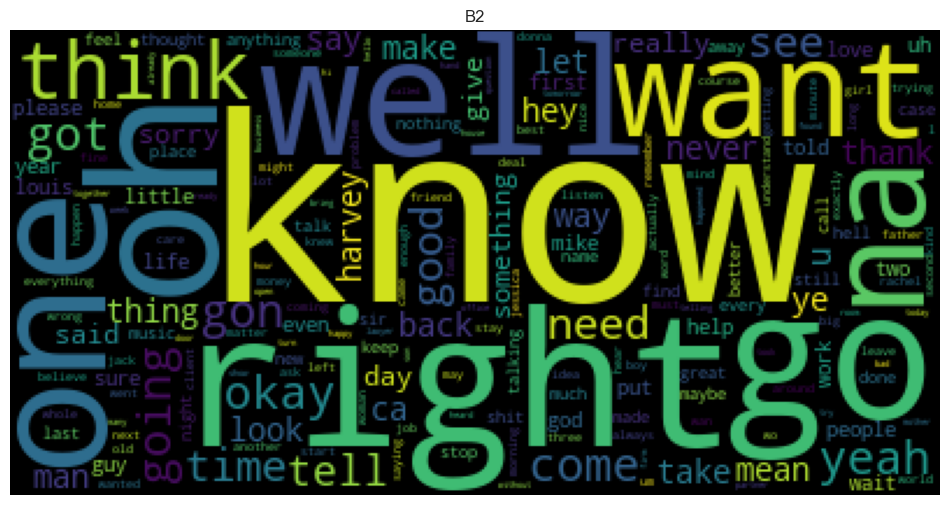

In [255]:
plt.figure(figsize=(12, 20))
wordcloud = WordCloud(collocations=False, stopwords=STOPWORDS, background_color='black').generate(' '.join(level_b2))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('B2')
plt.show()

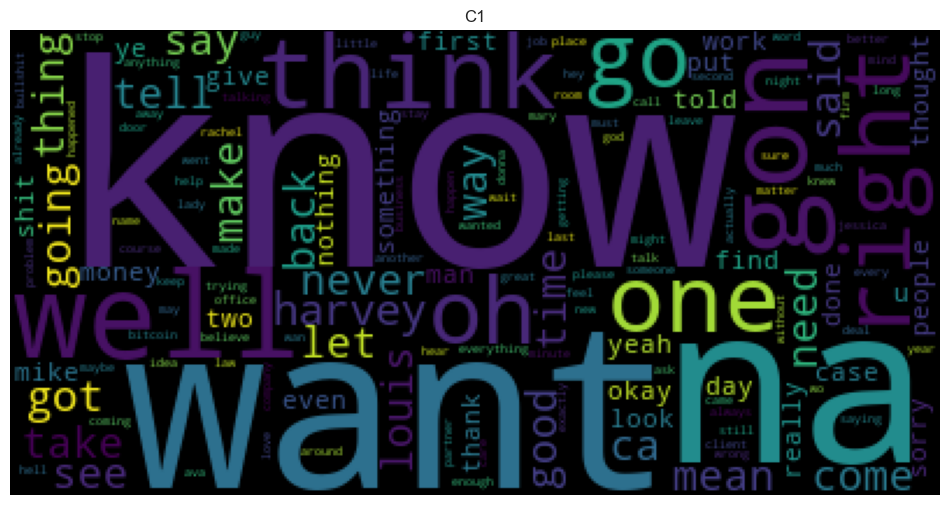

In [256]:
plt.figure(figsize=(12, 20))
wordcloud = WordCloud(collocations=False, stopwords=STOPWORDS, background_color='black').generate(' '.join(level_c1))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('C1')
plt.show()

# Обучение моделей

In [261]:
X = df['data'].apply(' '.join)
y = df['level']

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,  random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=1)

In [263]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
X_train = tfidf_vectorizer.transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)

## Logistic Regression

In [289]:
parameters = {
    'penalty' : [None, 'l2'], 
    'C'       : [1.0, 10.0, 100.0],
    'solver'  : ['newton-cg', 'lbfgs', 'sag'],
    'fit_intercept' : [True, False],
    'multi_class' : ['multinomial'],
    'random_state': [123]
}

In [290]:
model = LogisticRegression()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1_macro', error_score='raise') #imbalanced dataset, using F1 macro

In [291]:
grid.fit(X_train, y_train);

In [292]:
predictions = grid.predict(X_val)
print('f1_macro =', f1_score(y_val, predictions, average='macro'))

f1_macro = 0.5960489993098689


## Random Forest 

In [302]:
parameters = { 
    'n_estimators': [200, 500, 700],
    'max_depth' : [2, 5, 10, 20],
    'criterion' : ['gini', 'entropy'],
    'random_state' : [123]
}

In [303]:
model = RandomForestClassifier()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1_macro', error_score='raise') #imbalanced dataset, using F1 macro

In [304]:
grid.fit(X_train, y_train);

In [306]:
predictions = grid.predict(X_val)
print('f1_macro =', f1_score(y_val, predictions, average='macro'))

f1_macro = 0.21108058608058605


## XGBoost

In [325]:
parameters = {
    'n_estimators' : [200, 500, 700],
    'max_depth' : [2, 5, 10, 20],
    'learning_rate' : [0.1, 0.01, 0.05],
    'random_state' : [123]
}

In [315]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_val_enc = encoder.transform(y_val)

In [316]:
model = xgb.XGBClassifier()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1_macro', error_score='raise') #imbalanced dataset, using F1 macro

In [317]:
grid.fit(X_train, y_train_enc);

In [318]:
predictions = grid.predict(X_val)
print('f1_macro =', f1_score(y_val_enc, predictions, average='macro'))

f1_macro = 0.4973363774733638


## Pre-trained transformer

In [156]:
df['data'] = df['data'].apply(' '.join)

In [157]:
ds = Dataset.from_pandas(df.drop('movie', axis=1))
ds = ds.rename_column('level', 'label')
ds = ds.class_encode_column("label")

Casting to class labels:   0%|          | 0/280 [00:00<?, ? examples/s]

In [164]:
ds

Dataset({
    features: ['data', 'label'],
    num_rows: 280
})

In [159]:
model_nm = 'microsoft/deberta-v3-large'
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=True)

NameError: name 'AutoTokenizer' is not defined

In [ ]:
def tokz_func(data):
    return tokz(data['data'])

In [ ]:
ds_tokenized = ds.map(tokz_func, batched=True, remove_columns='data')

In [ ]:
ds_split = ds_tokenized.train_test_split(test_size=0.2, stratify_by_column='label', seed=1234)

In [ ]:
def correlation(eval_pred):
    return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
bs = 128
args = TFTrainingArguments('outputs', learning_rate=8e-5, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True, evaluation_strategy="epoch",
                         per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2, num_train_epochs=4, weight_decay=0.01, report_to='none')
trainer = TFTrainer(model, args, train_dataset=ds_split['train'], eval_dataset=ds_split['test'], compute_metrics=correlation)

In [ ]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
 # my output was => ['/device:CPU:0']
 # good output must be => ['/device:CPU:0', '/device:GPU:0']

In [ ]:
tf.debugging.set_log_device_placement(True) 

In [ ]:
tf.enable_eager_execution() 



# Explicitly place tensors on the DirectML device 

with tf.device('/DML:0'): 
    a = tf.constant([1.0, 2.0, 3.0]) 
    b = tf.constant([4.0, 5.0, 6.0]) 



c = tf.add(a, b) 

print(c)

In [ ]:
import sys
print (sys.version)
 # 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print(tf.__version__)
 # my output was => 1.13.1

In [ ]:
#trainer.train()